# LANGUAGE MODELING WITH NN.TRANSFORMER AND TORCHTEXT

This notebook is based on [PyTorch Transformer Tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) on training a sequence-to-sequence model that uses the nn.Transformer module.

I will try to as much notes as I can to each step in order to make the code clearer


In [1]:
! pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 2.1 MB/s 
     |████████████████████████████████| 138 kB 7.8 MB/s 
     |████████████████████████████████| 127 kB 63.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

### Define the model

In this notebook, we train a nn.TransformerEncoder model on a language modeling task. The language modeling task is to assign a probability for the likelihood of a given word (or a sequence of words) to follow a sequence of words. A sequence of tokens are passed to the embedding layer first, followed by a positional encoding layer to account for the order of the word (see the next paragraph for more details). The `nn.TransformerEncoder` consists of multiple layers of nn.TransformerEncoderLayer. Along with the input sequence, a square attention mask is required because the self-attention layers in `nn.TransformerEncoder` are only allowed to attend the earlier positions in the sequence. For the language modeling task, any tokens on the future positions should be masked. To produce a probability distribution over output words, the output of the nn.TransformerEncoder model is passed through a linear layer followed by a log-softmax function.

#### Quick note on Embedding Layer

Since ML/DL models take numbers as input, we need to map words in the text to numbers. Now, there are various ways we can do that - 

1. `One-Hot encoding` - Assign 1 to the word of interest, 0 to the rest and create a row in the matrix. But this becomes difficult to manage once corpus increases. This approach is inefficient. A one-hot encoded vector is sparse (meaning, most indices are zero). Imagine you have 10,000 words in the vocabulary. To one-hot encode each word, you would create a vector where 99.99% of the elements are zero.
2. `Number to Word Mapping` - A second approach you might try is to encode each word using a unique number. There are 2 downsides to this approach - 
  i. The integer-encoding is arbitrary (it does not capture any relationship between words).
 ii. An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful. 

3. `Word Embeddings` - Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

    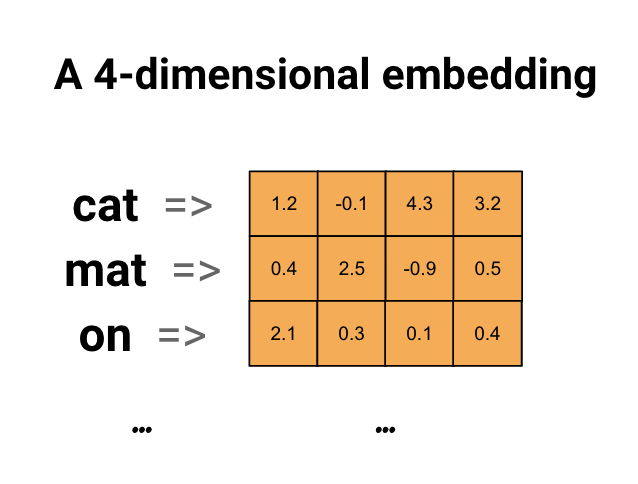

  Above is a diagram for a word embedding. Each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as "lookup table". After these weights have been learned, you can encode each word by looking up the dense vector it corresponds to in the table.

In [3]:
# an Embedding module containing 10 tensors of size 3
embedding = nn.Embedding(10, 3)
# a batch of 2 samples of 4 indices each
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
embedding(input)

tensor([[[ 0.2702,  0.4458,  0.2510],
         [ 0.7042,  0.1975, -0.8119],
         [-0.6112, -0.4812, -0.7792],
         [ 0.9726, -0.0993,  1.2450]],

        [[-0.6112, -0.4812, -0.7792],
         [ 0.6793, -0.0336,  0.3261],
         [ 0.7042,  0.1975, -0.8119],
         [ 0.5575,  0.3469,  0.5308]]], grad_fn=<EmbeddingBackward0>)

We initialized a lookup table of 10 rows and 3 columns. So, every index in the input matrix got converted to a dense vector of 3 elements, with the output for a key remaining the same (see output for index = 2 or index = 4)

### Define the model

In [4]:
# Define the Transformer Model Class

# Inherit from nn.Module - Base class for all neural network modules.All PyTorch models should also subclass this class
class TransformerModel(nn.Module):

    '''
    The class takes following inputs - 
      1. ntoken - Number of Tokens. Ideally would be the size of the vocabulary
      2. d_model - the number of expected features in the input
      3. nhead - the number of heads in the multiheadattention models
      4. d_hid - 
      5. nlayers - Number of Encoder Layers
      6. DropOut - DropOut percentage
    '''

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
      
        # Init nn.Module - It's the superclass for the TransformerModel
        super().__init__()
        # Define Model Type - Purely for reference
        self.model_type = 'Transformer'
        # Positional Encoder - To be explained later
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        # Initiate TransformerEncoderLayer - Standard encoder layer. TransformerEncoderLayer is made up of self-attn and feedforward network.
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        # Create a stack of encoder layers - TransformerEncoder is a stack of N encoder layers
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        # Create Embedding Layer - initialized with number of tokens (size of the dictionary of embeddings) 
        # and number of features expected in the input - so that the embedded output have the same length
        self.encoder = nn.Embedding(ntoken, d_model)
        # Assign value to the variable - number of features expected as input
        self.d_model = d_model
        # Define Decoder model - Applies a linear transformation to the incoming data: y=xA.T +b
        self.decoder = nn.Linear(d_model, ntoken)
        # Initialize weights
        self.init_weights()


    def init_weights(self) -> None:
        "Initialize weights for encoder and decoder"
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    
    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Defines 1 iteration of forward propogation
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """

        # Encode the input. Multiplication is a bit ambiguous and the explanation can be found here - https://datascience.stackexchange.com/a/87909
        src = self.encoder(src) * math.sqrt(self.d_model)
        # Add positional encoding
        src = self.pos_encoder(src)
        # Pass the input to encoder
        output = self.transformer_encoder(src, src_mask)
        # Pass encoder output to decoder
        output = self.decoder(output)
        return output

def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

generate_square_subsequent_mask function is used to create a matrix with -inf weights on the upper half of the matrix. This tells the algorithm to not look after the tokens after the current token

#### Positional Encoding

`PositionalEncoding` module injects some information about the relative or absolute position of the tokens in the sequence. The positional encodings have the same dimension as the embeddings so that the two can be summed. Here, we use sine and cosine functions of different frequencies.

In [5]:
class PositionalEncoding(nn.Module):
    '''
    Note that this is also a subclass of nn Module. 
    '''

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

### Load and batch data

This tutorial uses torchtext to generate Wikitext-2 dataset.

The vocab object is built based on the train dataset and is used to numericalize tokens into tensors. Wikitext-2 represents rare tokens as `<unk>`.

In [6]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [7]:
# Get training split of the data
train_iter = WikiText2(split='train')

In [8]:
# Initialize tokenizer
tokenizer = get_tokenizer('basic_english')

In [9]:
# Build vocab from the corpus
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])

In [10]:
# Set default token to <unk>
vocab.set_default_index(vocab['<unk>'])

In [11]:
# Convert text into flat tensors
def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# train_iter was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

In [12]:
# What exactly the funtion is doing on a piece of text

test_text = "I'll see you on the dark side of the moon! <unk>" # <unk> added specifically for demo

tokenized_item = tokenizer(test_text)
map_vocab = vocab(tokenized_item)
tensor_from_vocab = [torch.tensor(map_vocab, dtype=torch.long)]
tuple_of_tensors = tuple(filter(lambda t: t.numel() > 0, tensor_from_vocab))
concat_tensors = torch.cat(tuple_of_tensors)

print('Raw Text : ', test_text)
print('Tokenized Text : ', tokenized_item)
print('Vocab : ', map_vocab)
print('Tensor : ', tensor_from_vocab)
print('Tuple of Tensors : ', tuple_of_tensors)
print('Concatenated Tensors : ', concat_tensors)

Raw Text :  I'll see you on the dark side of the moon! <unk>
Tokenized Text :  ['i', "'", 'll', 'see', 'you', 'on', 'the', 'dark', 'side', 'of', 'the', 'moon', '!', '<unk>']
Vocab :  [64, 11, 2851, 548, 178, 13, 1, 1199, 321, 4, 1, 2374, 385, 0]
Tensor :  [tensor([  64,   11, 2851,  548,  178,   13,    1, 1199,  321,    4,    1, 2374,
         385,    0])]
Tuple of Tensors :  (tensor([  64,   11, 2851,  548,  178,   13,    1, 1199,  321,    4,    1, 2374,
         385,    0]),)
Concatenated Tensors :  tensor([  64,   11, 2851,  548,  178,   13,    1, 1199,  321,    4,    1, 2374,
         385,    0])


* The function tokenizes the text using 'basic_english' tokenizer
* Function converts the tokens (english still) into numbers based on the vocab built on the training data - stored in var 'vocab' in the above cell
* Function converts the list of vocab tokens (now numbers) into a pytorch tensor
* Function extracts all the sub-tensors with len > 0 (torch.numel function)
* Then, function concatenates all the sub-tensors into a single tensor using torch.cat()








`NOTE` : I've specifically added token <unk> in the input string to demo that the function won't remove the token where index from vocab is 0, rather the entire tensor where length of the tensor is not > 0

#### Batch the data

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [14]:
def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10

train_data = batchify(train_data, batch_size)  # shape [seq_len, batch_size]
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

In [15]:
# Let's do the same exercise with this function with another text

test_text = "And when the band you're in, starts playing different tunes, I'll see you on the dark side of the moon! <unk>" # <unk> added specifically for demo

tokenized_item = tokenizer(test_text)
map_vocab = vocab(tokenized_item)
tensor_from_vocab = [torch.tensor(map_vocab, dtype=torch.long)]
tuple_of_tensors = tuple(filter(lambda t: t.numel() > 0, tensor_from_vocab))
concat_tensors = torch.cat(tuple_of_tensors)
batched_item = batchify(concat_tensors, 5)

print('Raw Text : ', test_text)
print('Tokenized Text : ', tokenized_item)
print('Vocab : ', map_vocab)
print('Tensor : ', tensor_from_vocab)
print('Tuple of Tensors : ', tuple_of_tensors)
print('Concatenated Tensors : ', concat_tensors)
print('Tensor Shape before batchify : ', concat_tensors.size(0))
print('Batched Tensor : ', batched_item)
print('Tensor Shape after batchify : ', batched_item.size())

Raw Text :  And when the band you're in, starts playing different tunes, I'll see you on the dark side of the moon! <unk>
Tokenized Text :  ['and', 'when', 'the', 'band', 'you', "'", 're', 'in', ',', 'starts', 'playing', 'different', 'tunes', ',', 'i', "'", 'll', 'see', 'you', 'on', 'the', 'dark', 'side', 'of', 'the', 'moon', '!', '<unk>']
Vocab :  [5, 57, 1, 397, 178, 11, 401, 6, 2, 2034, 575, 367, 13839, 2, 64, 11, 2851, 548, 178, 13, 1, 1199, 321, 4, 1, 2374, 385, 0]
Tensor :  [tensor([    5,    57,     1,   397,   178,    11,   401,     6,     2,  2034,
          575,   367, 13839,     2,    64,    11,  2851,   548,   178,    13,
            1,  1199,   321,     4,     1,  2374,   385,     0])]
Tuple of Tensors :  (tensor([    5,    57,     1,   397,   178,    11,   401,     6,     2,  2034,
          575,   367, 13839,     2,    64,    11,  2851,   548,   178,    13,
            1,  1199,   321,     4,     1,  2374,   385,     0]),)
Concatenated Tensors :  tensor([    5,    57,   

So, the function divided the input sequence into batches of 'batch_size' and `discards` all the tokens which remain

In the above example, we started with 28 tokens and batched into batch_size of 5. So, 28 // 5 -> 5 and (28 - 5*5) = 3 elements from the last will be discarded

> Also notice the order in which batches are created. First 10 elements are [5, 57, 1, 397, 178, 11, 401, 6, 2, 2034]. These are created into 
[[5,11],
[57, 401],
[1,6],
[397,2]
[178, 2034]]

Order matters, and not exactly sure why we're doing this. Might find out later. It has to do with the transpose happening in the function, maybe because input tensor is fed into the network column-wise

The explanation is available in the doc - 

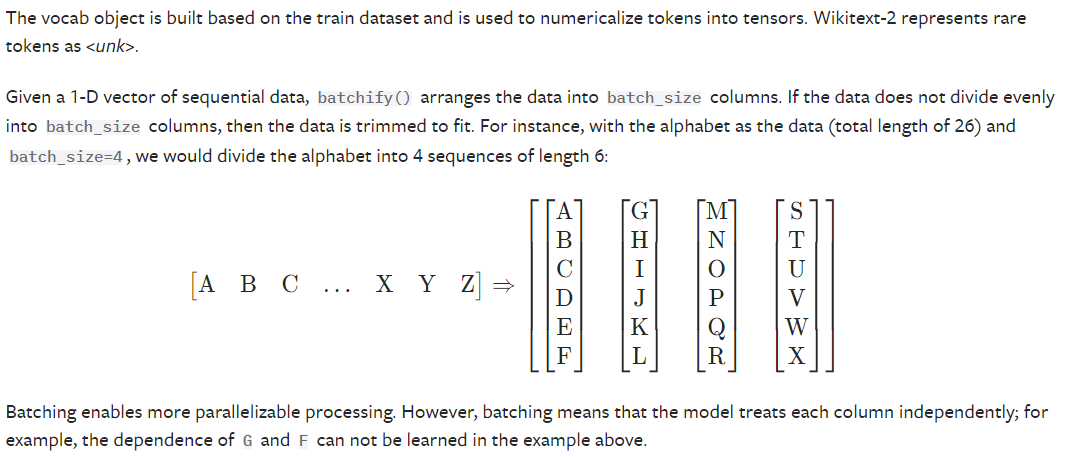

#### Functions to generate input and target sequence

get_batch() generates a pair of input-target sequences for the transformer model. It subdivides the source data into chunks of length bptt. For the language modeling task, the model needs the following words as Target. For example, with a bptt value of 2, we’d get the following two Variables for i = 0:


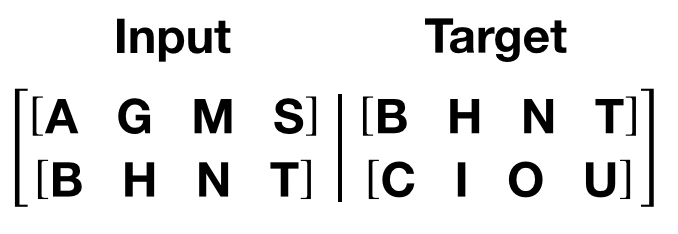



It should be noted that the chunks are along dimension 0, consistent with the S dimension in the Transformer model. The batch dimension N is along dimension 1.

In [16]:
bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [24]:
# Let's run the function on our string

print("Actual Tensor : ", batched_item)
print("Length of input tensor : ", len(batched_item))
print("Input sequence from the tensor : ", get_batch(batched_item,2)[0])
print("Output sequence from the tensor : ", get_batch(batched_item,2)[1])

Actual Tensor :  tensor([[    5,    11,   575,    11,     1],
        [   57,   401,   367,  2851,  1199],
        [    1,     6, 13839,   548,   321],
        [  397,     2,     2,   178,     4],
        [  178,  2034,    64,    13,     1]])
Length of input tensor :  5
Input sequence from the tensor :  tensor([[    1,     6, 13839,   548,   321],
        [  397,     2,     2,   178,     4]])
Output sequence from the tensor :  tensor([ 397,    2,    2,  178,    4,  178, 2034,   64,   13,    1])


A nice way to think about this would be to take any input token, the target should be the next word.

### Initiate an instance


The model hyperparameters are defined below. The vocab size is equal to the length of the vocab object.

In [ ]:
ntokens = len(vocab)  # size of vocabulary
emsize = 200  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # number of heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

### Model Training

We use CrossEntropyLoss with the SGD (stochastic gradient descent) optimizer. The learning rate is initially set to 5.0 and follows a StepLR schedule. During training, we use nn.utils.clip_grad_norm_ to prevent gradients from exploding.

`But, what is gradient explosion ?` 

From [DeepAI](https://deepai.org/machine-learning-glossary-and-terms/exploding-gradient-problem),
> Exploding gradients are a problem when large error gradients accumulate and result in very large updates to neural network model weights during training. Gradients are used during training to update the network weights, but when the typically this process works best when these updates are small and controlled. When the magnitudes of the gradients accumulate,  an unstable network is likely to occur, which can cause poor predicition results or even a model that reports nothing useful what so ever. There are methods to fix exploding gradients, which include gradient clipping and weight regularization, among others.

` Now, what is Gradient Clipping?`

> Gradient clipping is a technique to prevent exploding gradients in very deep networks, usually in recurrent neural networks. A neural network is a learning algorithm, also called neural network or neural net, that uses a network of functions to understand and translate data input into a specific output. This type of learning algorithm is designed based on the way neurons function in the human brain. There are many ways to compute gradient clipping, but a common one is to rescale gradients so that their norm is at most a particular value. With gradient clipping, pre-determined gradient threshold be introduced, and  then gradients norms that exceed this threshold are scaled down to match the norm.  This prevents any gradient to have norm greater than the threshold and thus the gradients are clipped.  There is an introduced bias in the resulting values from the gradient, but gradient clipping can keep things stable. 

`And, how does Gradient Clipping solve this problem?`

> Training recurrent neural networks can be very difficult. Two common issues with training recurrent neural networks are vanishing gradients and exploding gradients. Exploding gradients can occur when the gradient becomes too large and error gradients accumulate, resulting in an unstable network. Vanishing gradients can happen when optimization gets stuck at a certain point because the gradient is too small to progress. Gradient clipping can prevent these issues in the gradients that mess up the parameters during training.



In [ ]:
import copy
import time

# Loss function - This criterion computes the cross entropy loss between input and target. 
# It is useful when training a classification problem with C classes.
criterion = nn.CrossEntropyLoss()

lr = 5.0  # learning rate

# Optimizer - Implement stochastic gradient descent 
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Learning Rate Scheduler - Decays the learning rate of each parameter group by gamma every step_size epochs.
# Here, we've set step_size = 1, so we decay the LR every epoch by gamma
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)